# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


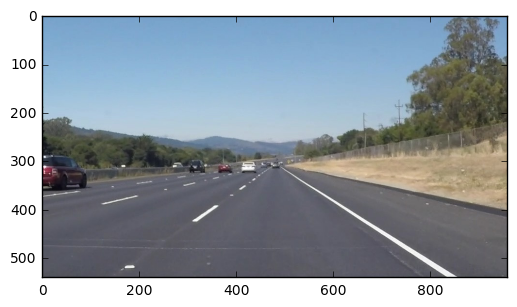

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def within(x, x_range):
    """
    Checks if a point in within a range of values
    """
    return ((x>=x_range[0]) & (x<=x_range[1]))

def exclude_outliers(data, m = 3.):
    """
    Detect the values which are which a certain 
    deviation from a the mediam centrality measure
    """
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d/mdev if mdev else 0.
    return s<m

def draw_smartlines(img, lines, color=[255, 0, 0], thickness=2, cap=1.02, interpolate=True):
    """
    Function to replace the draw_lines function
    Note: cap is a modifier for the y values of the line interpolation
    """
    # Initialization
    y_range = [0,img.shape[0]]
    x_range = [0,img.shape[1]]
    min_x = min_y = 9999
    max_x = max_y = 0   
    
    matrix = lines[:,0,:]

    # Cycle the segments in order to obtain their m,q linear coefficients
    # the cycle also filters uninteresting segments (based on x intercept and angle)
    # it also computes a weight based on the length of the segment
    # In the end it outputs a boolean vector for selection
    directions = []
    intercepts = []
    matrix_filter = []
    weight = []
    for line in lines:
        for x1,y1,x2,y2 in line:
            min_x = min(min_x,x1,x2)
            max_x = max(max_x,x1,x2)
            min_y = min(min_y,y1,y2)
            max_y = max(max_y,y1,y2)
            m,q = np.polyfit((x1,x2),(y1,y2), deg=1)
            # check on 1. intercept on visibile bottom x axis
            #          2. |m| being within 0.5 and 0.8 (other m are unlikely lane lines)
            if within((y_range[1]-q)/m,x_range) and 0.5<=np.abs(m)<=0.8:
                directions.append(m)
                intercepts.append(q)
                weight.append(np.sqrt((x1-x2)**2+(y1-y2)**2))
                matrix_filter.append(True)
            else:
                matrix_filter.append(False)

    # Lists are convenient, but Numpy arrays are better
    directions = np.array(directions)
    intercepts = np.array(intercepts)
    weight = np.array(weight) / np.sum(weight)

    left = (directions>=0) 
    left_valid = (exclude_outliers(directions[left]))

    right = (directions<0)
    right_valid = (exclude_outliers(directions[right]))

    min_y = int(min_y * cap)

    try:
        left_side  = matrix[np.array(matrix_filter)][left][left_valid]
        if interpolate:
            # left side m and q values are averaged by weights in order to find the interpolation
            if len(left_side) >= 0:
                x = np.append(left_side[:,0], left_side[:,2])
                y = np.append(left_side[:,1], left_side[:,3])
                m = np.sum(directions[left][left_valid] * (weight[left][left_valid] / np.sum(weight[left][left_valid])))
                q = np.sum(intercepts[left][left_valid] * (weight[left][left_valid] / np.sum(weight[left][left_valid])))
                cv2.line(img, (int((max_y-q)/m),max_y), (int((min_y-q)/m),min_y), color, thickness)
        else:
            for x1,y1,x2,y2 in left_side:
                cv2.line(img, (x1,y1), (x2,y2), color, thickness)
    except:
        pass

    try:
        right_side = matrix[np.array(matrix_filter)][right][right_valid]
        if interpolate:
            # right side m and q values are averaged by weights in order to find the interpolation
            if len(right_side) >= 0:
                x = np.append(right_side[:,0], right_side[:,2])
                y = np.append(right_side[:,1], right_side[:,3])
                m = np.sum(directions[right][right_valid] * (weight[right][right_valid] / np.sum(weight[right][right_valid])))
                q = np.sum(intercepts[right][right_valid] * (weight[right][right_valid] / np.sum(weight[right][right_valid])))
                cv2.line(img, (int((max_y-q)/m),max_y), (int((min_y-q)/m),min_y), color, thickness)
        else:
            for x1,y1,x2,y2 in right_side:
                cv2.line(img, (x1,y1), (x2,y2), color, thickness)
    except:
        pass
    
                    
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros(img.shape, dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'whiteCarLaneSwitch.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'solidWhiteRight.jpg']

run your solution on all test_images and make copies into the test_images directory).

In [5]:
def color_select(image, red_threshold = 200, green_threshold = 200, blue_threshold = 0):
    rgb_threshold = [red_threshold, green_threshold, blue_threshold]
    thresholds = (image[:,:,0] < rgb_threshold[0]) \
                | (image[:,:,1] < rgb_threshold[1]) \
                | (image[:,:,2] < rgb_threshold[2])

    color_select = np.copy(image)
    color_select[thresholds] = [0,0,0]
    return color_select

def find_edges(image, low_threshold = 50, high_threshold = 150):
    return canny(image, low_threshold, high_threshold)

def cone_vision(image, height=0.5, width=1.0):
    # Grab the x and y size
    ysize = image.shape[0]
    xsize = image.shape[1]
    offset = int((1.0 - width) * xsize)
    vertices = np.array([[(0+offset,ysize),(xsize*0.5, ysize*(1-height)), (xsize-offset, ysize)]], dtype=np.int32)
    mask = np.zeros_like(image)   
    ignore_mask_color = 255   
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    return cv2.bitwise_and(image, mask)

def hodge_detect(image, rho = 2, theta = np.pi/180, threshold = 15, 
                 min_line_length = 20, max_line_gap = 20,
                drawing=draw_lines):
    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    #rho: distance resolution in pixels of the Hough grid
    #theta: angular resolution in radians of the Hough grid
    #threshold: minimum number of votes (intersections in Hough grid cell)
    #min_line_length: minimum number of pixels making up a line
    #max_line_gap: maximum gap in pixels between connectable line segments
    line_image = np.copy(image)*0 # creating a blank to draw lines on

    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    lines = cv2.HoughLinesP(image, rho, theta, threshold, np.array([]),
                            min_line_length, max_line_gap)

    # Iterate over the output "lines" and draw lines on a blank image
    drawing(line_image, lines, thickness=2)
    return np.dstack((line_image, np.zeros_like(line_image), np.zeros_like(line_image)))

In [6]:
original = os.listdir("test_images/")
solution  = ['solution_' + one for one in original] 

## Step by step procedure

In [7]:
image_name = original[0]

solidWhiteCurve.jpg
This image is:  <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


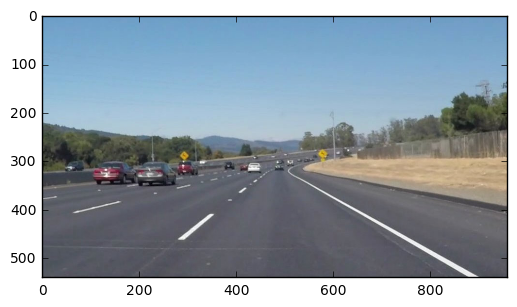

In [8]:
# Read in the image and print out some stats
print(image_name)
image = mpimg.imread("test_images/"+image_name)
print('This image is: ',type(image), 
         'with dimensions:', image.shape)

plt.imshow(image)

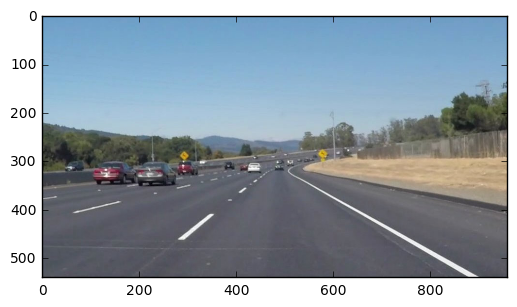

In [9]:
# Display the image (as it is, no colour filter is applied, though it could be)
A = color_select(image,red_threshold = 0, green_threshold = 0, blue_threshold = 0)
plt.imshow(A)

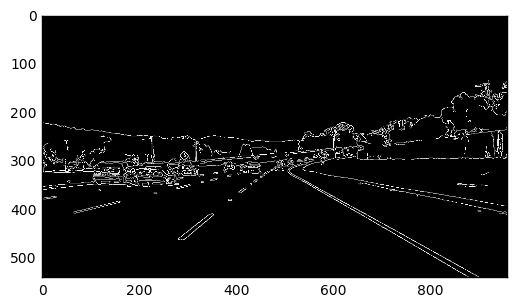

In [10]:
# Display the edges (edges are found using canny edges)
B = find_edges(A, low_threshold = 50, high_threshold = 150)
plt.imshow(B, cmap='Greys_r')

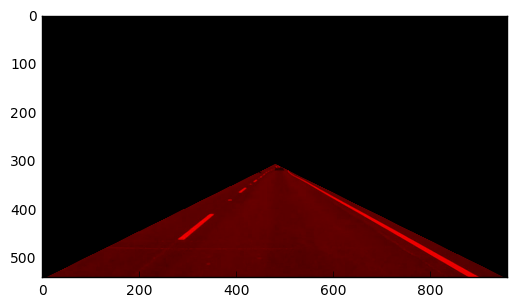

In [11]:
# We test limiting out vision to a part of the image, where the lanes are
C = cone_vision(A, height=0.43, width=0.99)
plt.imshow(C)

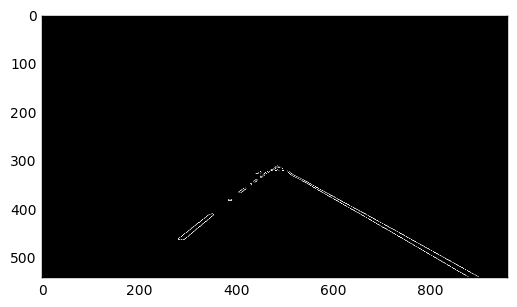

In [12]:
# Display the visual cone (now we keep on working with edges)
C = cone_vision(B, height=0.43, width=1.0)
plt.imshow(C, cmap='Greys_r')

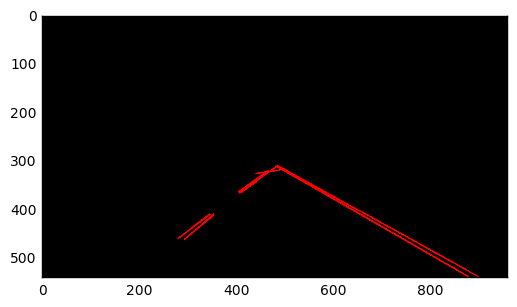

In [13]:
# Draw the lines on the edge image (we use the Hodge transformation)
# Notice that we sure pick the lane but also some noise by the standard draw_lines function
D = hodge_detect(C, rho = 1, theta = np.pi/180, threshold = 10, min_line_length = 32, max_line_gap = 16)
plt.imshow(D)

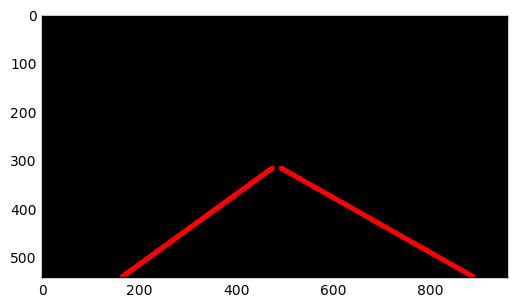

In [14]:
# Draw the filtered & interpolated lines on the edge image
# Using the draw_smartlines function, we can project only the lanes
D = hodge_detect(C, rho = 1, theta = np.pi/180, threshold = 10, min_line_length = 32, max_line_gap = 16,
                drawing = lambda line_image, lines, thickness: draw_smartlines(line_image, lines, thickness=10))
plt.imshow(D)

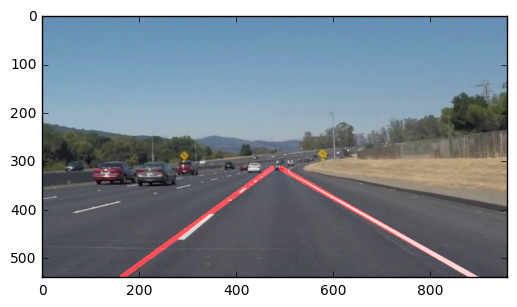

In [15]:
# We overimpose the result on the initial image
lines = D
overimpose = weighted_img(lines, image, α=0.9, β=1., λ=0.5)
plt.imshow(overimpose)

## Testing all images

In [16]:
# Here we simply define the pipeline, with all the set parameters
# changing anything is easy: first we try simply to mark the lanes
def drawing_lanes(image):
    lines = hodge_detect(cone_vision(
            find_edges(
                color_select(image, red_threshold = 0, green_threshold = 0, blue_threshold = 0)
                ,low_threshold = 50, high_threshold = 150)
                , height=0.43, width=0.99)
                ,rho = 1, theta = np.pi/180, threshold = 10, min_line_length = 32, max_line_gap = 16
                ,drawing = lambda line_image, lines, thickness: draw_smartlines(line_image, lines, thickness=10, interpolate=False))
    overimpress = weighted_img(lines, image, α=0.9, β=1., λ=0.5)
    return overimpress

solidWhiteCurve.jpg
This image is:  <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


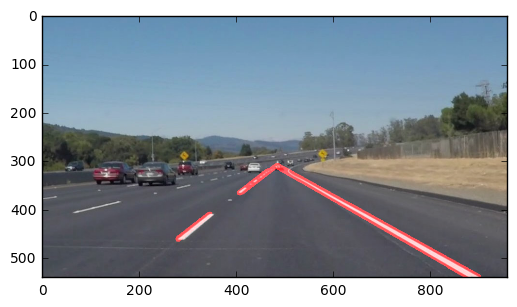

whiteCarLaneSwitch.jpg
This image is:  <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


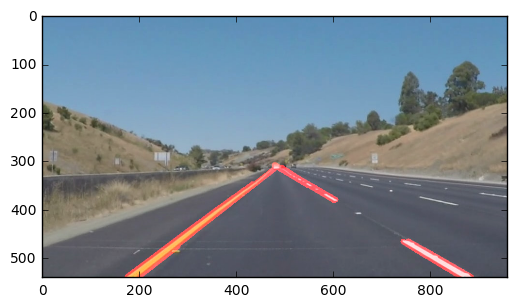

solidYellowCurve.jpg
This image is:  <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


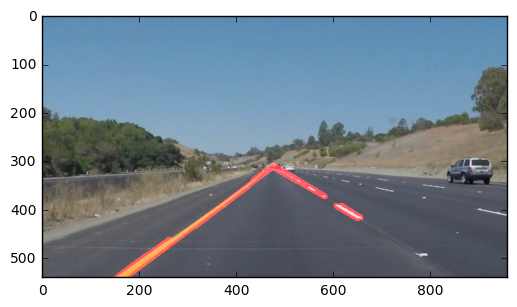

solidYellowCurve2.jpg
This image is:  <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


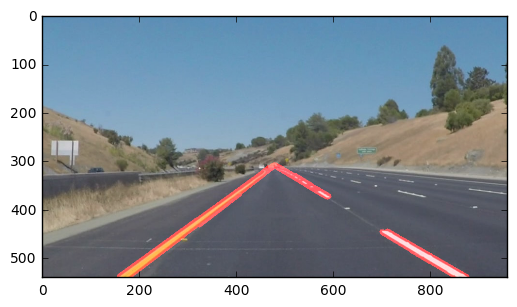

solidYellowLeft.jpg
This image is:  <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


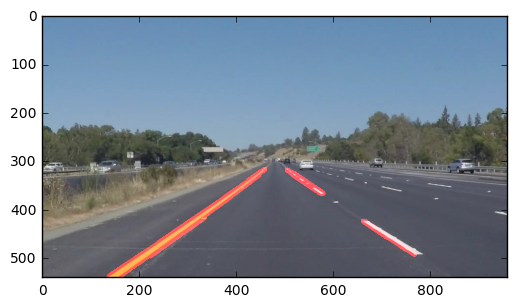

solidWhiteRight.jpg
This image is:  <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


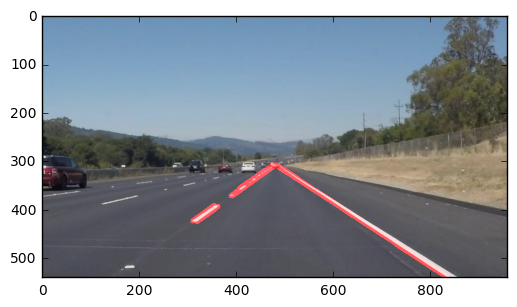

In [17]:
# As a test we apply the solution to every picture
for image_name, target_name in zip(original, solution):
    print(image_name)
    image = mpimg.imread("test_images/"+image_name)
    print('This image is: ',type(image), 
             'with dimensions:', image.shape)

    plt.imshow(drawing_lanes(image))
    plt.show()

In [18]:
# Here we simply define the pipeline, with all the set parameters
# changing anything is easy: then we interpolate
def drawing_lanes(image):
    lines = hodge_detect(cone_vision(
            find_edges(
                color_select(image, red_threshold = 0, green_threshold = 0, blue_threshold = 0)
                ,low_threshold = 50, high_threshold = 150)
                , height=0.43, width=0.99)
                ,rho = 1, theta = np.pi/180, threshold = 10, min_line_length = 32, max_line_gap = 16
                ,drawing = lambda line_image, lines, thickness: draw_smartlines(line_image, lines, thickness=10))
    overimpress = weighted_img(lines, image, α=0.9, β=1., λ=0.5)
    return overimpress

solidWhiteCurve.jpg
This image is:  <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


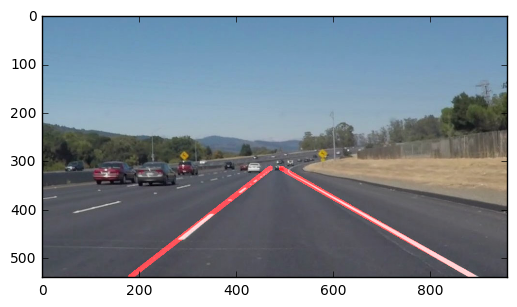

whiteCarLaneSwitch.jpg
This image is:  <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


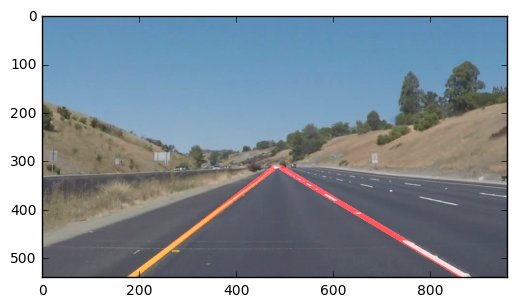

solidYellowCurve.jpg
This image is:  <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


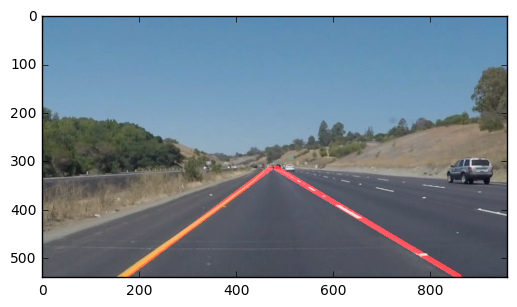

solidYellowCurve2.jpg
This image is:  <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


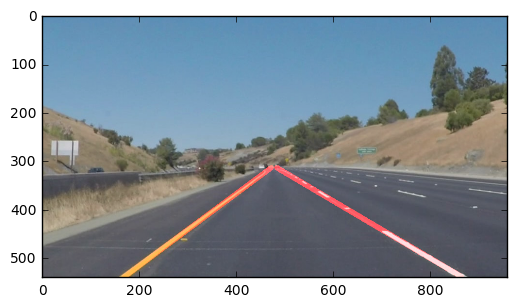

solidYellowLeft.jpg
This image is:  <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


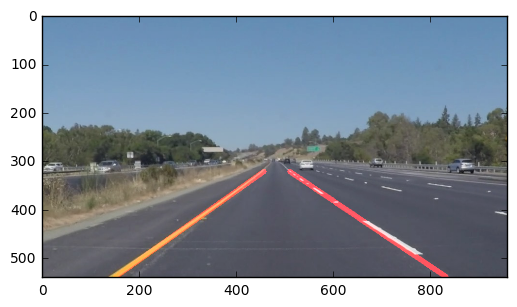

solidWhiteRight.jpg
This image is:  <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


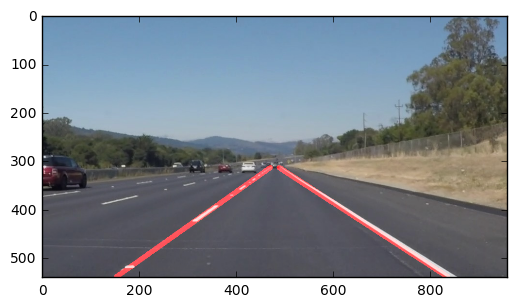

In [19]:
# As a test we apply the solution to every picture
for image_name, target_name in zip(original, solution):
    print(image_name)
    image = mpimg.imread("test_images/"+image_name)
    print('This image is: ',type(image), 
             'with dimensions:', image.shape)

    plt.imshow(drawing_lanes(image))
    plt.show()

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [20]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [21]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    result = drawing_lanes(image)
    return result

Let's try the one with the solid white lane on the right first ...

In [22]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:05<00:00, 38.37it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 3.98 s, sys: 196 ms, total: 4.17 s
Wall time: 6.32 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [23]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [24]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:17<00:00, 38.40it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 12.7 s, sys: 500 ms, total: 13.2 s
Wall time: 18.3 s


In [25]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!


### My reflections

The pipeline has been thought as a series of functions that can be nexted into each other. With more time I could prepare a class out of them. 

The functions I used are the ones I learned from the lesson. 

In order to project and interpolate correctly the lanes I used some intuitive checks such as lanes should intersecate the bottom border, they should have a angular coefficient in a certain range, they should not be outlying (based on robust measures of median and deviance) or they are somehting else. When projecting a sigle line for the lane, the most interesting break-through was, anyway, to simply average the angular coefficients and the intercepts, weighting more those whose segments are longer.

Since this algorithm is based on a few examples, in order to make it better and more robust I would test it under multiple conditions and on much more examples than the few ones it has been tested on. In particular I expect problems from different light conditions, different camera settings (as seen in the extra challenge), curve roads, bumps, ups and downs and especially from cars, which they may hide or confound the extend and direction of the lanes.

How would I make the algorithm better:

* automatic parameter settings
* persistence of previous lanes, that is the lane line is not calculated for each frame, but multiple frames are averaged (like in exponential smoothing) in order to have a "memory" of the lane

As for as the extra challenge, in the pipeline I just changed how the canny edge detector work (higher low and high thresholds) and capped the lane lines or they would intersecate since the road is curving.


Luca Massaron lucamassaron@gmail.com

## Submission

If you're satisfied with your video outputs it's time to submit!


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [41]:
def drawing_lanes(image):
    lines = hodge_detect(cone_vision(
            find_edges(
                color_select(image, red_threshold = 0, green_threshold = 0, blue_threshold = 0)
                ,low_threshold = 200, high_threshold = 250)
                , height=0.43, width=0.99)
                ,rho = 1, theta = np.pi/180, threshold = 10, min_line_length = 32, max_line_gap = 16
                ,drawing = lambda line_image, lines, thickness: draw_smartlines(line_image, lines, thickness=10, cap=1.12))
    overimpress = weighted_img(lines, image, α=0.9, β=1., λ=0.5)
    return overimpress

In [42]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [00:10<00:00, 23.06it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 7.56 s, sys: 248 ms, total: 7.81 s
Wall time: 12 s


In [43]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))